## Generating evidences for TF annotation  

In [ ]:
#Run all this in the terminal
# Download the databases
# swissprot
wget https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/complete/uniprot_sprot.fasta.gz

#hsym.pep was removed of * at the end of the peptide sequences so interpro doesn't complain
#Interproscan searching pfam and panther matches
../../my_interproscan/interproscan-5.60-92.0/interproscan.sh \
-i ../hysim_interpro.pep -d ./ --cpu 12 -goterms --appl Pfam,PANTHER

#Interproscan searching superfamily matches
../../my_interproscan/interproscan-5.60-92.0/interproscan.sh \
-i ../hysim_interpro.pep -d ./ --cpu 12 -goterms --appl SUPERFAMILY

#Link or rename each tsv file accordingly

## Reciprocal blast to get the best top hits with uniprot  

In [ ]:
makeblastdb -dbtype prot -in ./hysim_namesmod.pep

blastp -db ./hysim_namesmod.pep \
       -query $PATH/DATA/static/databases/uniprot_swissprot/uniprot_sprot.fasta \
       -max_target_seqs 1 -outfmt 6 -evalue 1e-5 -num_threads 10 > ./swissprot_hysim.out

blastp -query ./hysim_namesmod.pep \
       -db $PATH/DATA/static/databases/uniprot_swissprot/uniprot_sprot.fasta \
       -max_target_seqs 1 -outfmt 6 -evalue 1e-5 -num_threads 10 > ./hysim_swissprot.out

awk '{OFS="_"} {print($1,$2)}' hysim_swissprot.out| sort | uniq > hysim_swissprot.txt
awk '{OFS="_"} {print($2,$1)}' swissprot_hysim.out| sort | uniq > swissprot_hysim.txt

#There are different ways to find the intersection between these two files
#all the three methods below work in similar way
grep -Ff swissprot_hysim.txt hysim_swissprot.txt > test1
grep -Fx -f swissprot_hysim.txt hysim_swissprot.txt > test2 #decided to go with this option, but further testing needs to be done
comm -12 <(sort swissprot_hysim.txt) <(sort hysim_swissprot.txt)> test3

#this last one keeps both matches in the same line, not necessarily usefull for this purpose
join <(sort swissprot_hysim.txt) <(sort hysim_swissprot.txt) > test4

#resulting file in Hydractinia_swissprot_REPBESTHIT.tsv

## EggNOG mapping

In [ ]:
#downloading and setting up the database
wget https://github.com/eggnogdb/eggnog-mapper/archive/refs/tags/2.1.10.tar.gz
tar xzvf 2.1.10.tar.gz
sudo python3 download_eggnog_data.py
#running the command
../eggnog-mapper-2.1.10/emapper.py --cpu 12 -i hysim_namesmod.pep\
--itype proteins -m diamond --sensmode sensitive --target_orthologs all\
--go_evidence non-electronic --output ./hysim_eggnog

#retrieve the names used for annotation
cut -f1,9 ./hysim_eggnog.emapper.annotations > hysim_eggnog_preferred_names.tsv

#retrieve the GO terms which are going to be used in the topGO package
cut -f1,10 ./hysim_eggnog.emapper.annotations > hysim_eggnog_GOs.tsv

#retrieve gene-COG table to use later in the analysis
cut -f1,7 ./hysim_eggnog.emapper.annotations > hysim_eggnog_COGs.tsv

## Orthofinder to classify the TFs into orthogroups accordingly to the better annotated database

In [ ]:
#when installing orthofinder use python3.7 and diamond 0.9.24
conda create -n orthofinder -c bioconda orthofinder

# Genomes from ENSEMBL were downloaded with gget and genomepy
# Dmel, Drer, Hsap, Mmus, Smed, Xtro were used togehter with hysim_longest.pep
# More cnidarian species had to be included to not have long branch effects by triploblastic animals
# Hvu (Hydra vulgaris), Nve (Nematostella vectensis), Ami (Acropora millepora),
# Spu (Strongylocentrotus purpuratus), Tad (Tricoplax adhaerens)

orthofinder -t 12 -M dendroblast -S diamond -f proteomes/
ln -s ./orthofinder/proteomes/OrthoFinder/Results_Jul14/Orthogroups/Orthogroups.tsv
./hsym_orthogroups.tsv

# Gathering evidences of TF annotation in R

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import harmonypy as hm
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp

In [ ]:
%matplotlib inline
sc.set_figure_params(dpi=300)

import seaborn as sns
sns.set(style="whitegrid")
%load_ext rpy2.ipython

### Setup of the working environment  

In [ ]:
%%R
dir <- "$PATH/interpro_diamond_blast/hydractinia_only/"
setwd(dir)

fcha <- function(){ gsub("-","",Sys.Date()) }

library(vroom)
library(dplyr)
library(reshape2)
library(stringi)
library(tidyr)
library(VennDiagram)
display_venn <- function(x, ...){
  library(VennDiagram)
  grid.newpage()
  venn_object <- venn.diagram(x, filename = NULL, ...)
  grid.draw(venn_object)
}

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
Attaching package: ‘tidyr’


R[write to console]: The following object is masked from ‘package:reshape2’:

    smiths


R[write to console]: Loading required package: grid

R[write to console]: Loading required package: futile.logger



#### Merging sources of evidence

In [ ]:
%%R
## the protein ids of these sequences were greped into a txt file
hysim_ids <- read.table("./hsym.pep.ids.txt"); colnames(hysim_ids) <- c("id")

hysim_TFS_fulltable <- data.frame( id= hysim_ids$id)

In [ ]:
%%R
## Pfam
pfam_list <- read.delim2("./pfam_panther/hsym_pep_names_mod.fa.tsv", header=F)
pfam_list <- unique(pfam_list[,c(1,5,6,13,14)])
colnames(pfam_list)<- c("id","PF","PF_name","PF_group?","GO")

hysim_TFS_fulltable <- merge(hysim_TFS_fulltable, pfam_list, by.x=1, by.y=1, all.x=T)

In [ ]:
%%R
head(pfam_list)

              id        PF                                        PF_name
1 XP_057309572.1   PF03901           Alg9-like mannosyltransferase family
2 XP_057309572.1 PTHR22760                            GLYCOSYLTRANSFERASE
3 XP_057312515.1 PTHR10159           DUAL SPECIFICITY PROTEIN PHOSPHATASE
4 XP_057312515.1   PF00782 Dual specificity phosphatase, catalytic domain
5 XP_057308742.1 PTHR22930                                UNCHARACTERIZED
6 XP_057308742.1   PF13359                   DDE superfamily endonuclease
                                       PF_group?                    GO
1                        GPI mannosyltransferase            GO:0016757
2                        GPI mannosyltransferase            GO:0016757
3                                              -                      
4 Dual specificity phosphatase, catalytic domain GO:0008138|GO:0016311
5                                              -                      
6  Harbinger transposase-derived nuclease domain        

In [ ]:
%%R
## Superfamily
supfam_list <- read.delim2("./superfamily/hsym_pep_names_mod.fa.tsv", header=F)
supfam_list <- unique(supfam_list[,c(1,6,13)])
colnames(supfam_list) <- c("id","SF_domain","SF_superfam")

hysim_TFS_fulltable <- merge(hysim_TFS_fulltable, supfam_list, by.x=1, by.y=1, all.x=T)

In [ ]:
%%R
head(supfam_list)

              id                                 SF_domain
1 XP_057312515.1 (Phosphotyrosine protein) phosphatases II
2 XP_057301354.1                            Ankyrin repeat
4 XP_057289341.1                                   Ras GEF
5 XP_057294130.1                               BRCT domain
6 XP_057294130.1                            Ankyrin repeat
8 XP_057294130.1                                RING/U-box
                                                SF_superfam
1                         Protein-tyrosine phosphatase-like
2              Ankyrin repeat-containing domain superfamily
4 Ras guanine nucleotide exchange factor domain superfamily
5                                   BRCT domain superfamily
6              Ankyrin repeat-containing domain superfamily
8                                                         -


In [ ]:
%%R
## Reciprocal blastps

hysim_blastp_list <- read.table("./swissprot/Hydractinia_swissprot_REPBESTHITS_namesmod.tsv", sep= "=", header=F)

colnames(hysim_blastp_list) <- c("id","rbhit_organism")

##already downloaded blast database
blastp_list_TFs <- read.delim2(
  "$PATH/DATA/static/databases/uniprot_swissprot/20220708_swissprot_TFs.tsv",
  header = F)

In [ ]:
%%R
head(hysim_blastp_list)

              id        rbhit_organism
1 XP_057289301.1  sp|P04818|TYSY_HUMAN
2 XP_057289302.1 sp|Q7L8A9|VASH1_HUMAN
3 XP_057289309.1 sp|P97314|CSRP2_MOUSE
4 XP_057289313.1 sp|Q91584|ELAV3_XENLA
5 XP_057289317.1 sp|O18973|RABX5_BOVIN
6 XP_057289318.1 sp|Q9UJ41|RABX5_HUMAN


In [ ]:
%%R
head(hysim_blastp_list)

              id        rbhit_organism
1 XP_057289301.1  sp|P04818|TYSY_HUMAN
2 XP_057289302.1 sp|Q7L8A9|VASH1_HUMAN
3 XP_057289309.1 sp|P97314|CSRP2_MOUSE
4 XP_057289313.1 sp|Q91584|ELAV3_XENLA
5 XP_057289317.1 sp|O18973|RABX5_BOVIN
6 XP_057289318.1 sp|Q9UJ41|RABX5_HUMAN


In [ ]:
%%R
#Filter only hits from TFs and add description
hysim_blastp_list_TFs <- merge(hysim_blastp_list, blastp_list_TFs,
                               by.x = 2, by.y = 1
                              )[,c(2,1,3)]; colnames(hysim_blastp_list_TFs)[3] <- "rbhit_description"

#merge with the full tables of evidence
hysim_TFS_fulltable <- merge(hysim_TFS_fulltable, hysim_blastp_list_TFs,
                             by.x = 1, by.y = 1, all.x = T)

In [ ]:
%%R
## Orthofinder

hysim_orthogroups <- vroom(file = "./hsym_orthogroups.tsv",)
animaltfdb <- read.delim2(
  "$PATH/DATA/static/databases/animalTFDB/20220707_animalTFDB3_0.tsv", header = T)

animaltfdb <- animaltfdb[!(animaltfdb$Species == "Caenorhabditis_elegans"),]
#removed c elegans since it was not used in Orthofinder
animaltfdb <- unique(animaltfdb  %>% separate_rows("Protein"))[,c(5,4,2,1)]
animaltfdb <- as.data.frame(animaltfdb[!(animaltfdb$Protein == ""),])

hysim_orthogroups <- hysim_orthogroups[
  !(is.na ( hysim_orthogroups$Hsim)),
]



Rows: 49014 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (13): Orthogroup, Ami, Dmel, Drer, Hsap, Hsim, Hvu, Mmus, Nve, Smed, Spu...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
%%R
colnames(hysim_orthogroups)
# check that each species is organized in the right positon to subset it

 [1] "Orthogroup" "Ami"        "Dmel"       "Drer"       "Hsap"      
 [6] "Hsim"       "Hvu"        "Mmus"       "Nve"        "Smed"      
[11] "Spu"        "Tad"        "Xtro"      


In [ ]:
%%R
head(hysim_orthogroups[,c(1,5)])

# A tibble: 6 × 2
  Orthogroup Hsap                                                               
  <chr>      <chr>                                                              
1 OG0000000  ENSP00000222726.3, ENSP00000222728.3, ENSP00000225648.3, ENSP00000…
2 OG0000001  ENSP00000005995.3, ENSP00000156499.3, ENSP00000161006.3, ENSP00000…
3 OG0000002  ENSP00000086933.2, ENSP00000221996.5, ENSP00000226382.2, ENSP00000…
4 OG0000003  ENSP00000260682.6, ENSP00000285979.6, ENSP00000291764.3, ENSP00000…
5 OG0000004  ENSP00000162391.3, ENSP00000250448.3, ENSP00000261302.5, ENSP00000…
6 OG0000005  <NA>                                                               


In [ ]:
%%R
#Create and properly format a table with every TF protein + orthogroup + symbol ID etc.
{
#get the families in a format family <--> gene
hysim_fams <- as.data.frame(
  hysim_orthogroups[,c(1,6)] %>%
    melt("Hsim") %>%
    mutate(Hsim=strsplit(Hsim, ",")) %>%
    unnest(Hsim)
)[,c(1,3)] ; colnames(hysim_fams) = c("id","og")

#hsap
hsap_fams <- as.data.frame(
  hysim_orthogroups[c(1,5)] %>%
  melt("Hsap") %>%
  mutate(Hsap=strsplit(Hsap, ",")) %>%
  unnest(Hsap)
)[,c(1,3)] ; colnames(hsap_fams) = c("id","og")

hsap_fams$id <-
  stri_replace_all_regex(hsap_fams$id,
                         pattern=c("N ", "\\..*"),
                         replacement=c("", ""),
                         vectorize=FALSE)

hsap_fams <- merge(
  hsap_fams,
  animaltfdb,
  by.x = 1,
  by.y = 1,
  all = F
)
#drer
drer_fams <- as.data.frame(
  hysim_orthogroups[,c(1,4)] %>%
  melt("Drer") %>%
  mutate(Drer=strsplit(Drer, ",")) %>%
  unnest(Drer)
)[,c(1,3)] ; colnames(drer_fams) = c("id","og")

drer_fams$id <-
  stri_replace_all_regex(drer_fams$id,
                         pattern=c("N ", "\\..*"),
                         replacement=c("", ""),
                         vectorize=FALSE)

drer_fams <- merge(
  drer_fams,
  animaltfdb,
  by.x = 1,
  by.y = 1,
  all = F
)

#mmus
mmus_fams <-as.data.frame(
  hysim_orthogroups[,c(1,8)] %>%
  melt("Mmus") %>%
  mutate(Mmus=strsplit(Mmus, ",")) %>%
  unnest(Mmus)
)[,c(1,3)] ; colnames(mmus_fams) = c("id","og")

mmus_fams$id <-
  stri_replace_all_regex(mmus_fams$id,
                         pattern=c("N ", "\\..*"),
                         replacement=c("", ""),
                         vectorize=FALSE)

mmus_fams <- merge(
  mmus_fams,
  animaltfdb,
  by.x = 1,
  by.y = 1,
  all = F
)

#dmel
dmel_fams <-as.data.frame(
  hysim_orthogroups[,c(1,3)] %>%
    melt("Dmel") %>%
    mutate(Dmel=strsplit(Dmel, ",")) %>%
    unnest(Dmel)
)[,c(1,3)] ; colnames(dmel_fams) = c("id","og")

dmel_fams$id <-
  stri_replace_all_regex(dmel_fams$id,
                         pattern=c("N ", "\\..*"),
                         replacement=c("", ""),
                         vectorize=FALSE)

dmel_fams <- merge(
  dmel_fams,
  animaltfdb,
  by.x = 1,
  by.y = 1,
  all = F
)

}


In [ ]:
%%R
head(hysim_fams)

               id        og
1  XP_057289799.1 OG0000000
2  XP_057289947.1 OG0000000
3  XP_057293392.1 OG0000000
4  XP_057295735.1 OG0000000
5  XP_057297592.1 OG0000000
6  XP_057301563.1 OG0000000


In [ ]:
%%R
(hysim_TFS_fulltable[1:5,])

              id        PF                     PF_name
1 XP_057289300.1      <NA>                        <NA>
2 XP_057289301.1 PTHR11548      THYMIDYLATE SYNTHASE 1
3 XP_057289301.1   PF00303        Thymidylate synthase
4 XP_057289302.1   PF14822                   Vasohibin
5 XP_057289302.1 PTHR15750 VASOHIBIN-1-LIKE ISOFORM X2
                                          PF_group?                    GO
1                                              <NA>                  <NA>
2        Thymidylate synthase/dCMP hydroxymethylase            GO:0016741
3 Thymidylate synthase/dCMP hydroxymethylase domain                     -
4                    Tubulinyl-Tyr carboxypeptidase GO:0005737|GO:0045765
5                    Tubulinyl-Tyr carboxypeptidase GO:0005737|GO:0045765
                                   SF_domain
1                                       <NA>
2 Thymidylate synthase/dCMP hydroxymethylase
3 Thymidylate synthase/dCMP hydroxymethylase
4                                       <NA>
5

In [ ]:
%%R
# Merging of all the gfams
fams_merging <- unique(
  merge(
  dmel_fams[,2:4],
    merge(
      drer_fams[,2:4],
      merge(
        hsap_fams[,2:4],
        mmus_fams[,2:4],
        by=1,
        all=T
      ),
      by=1,
      all=T
    ),
  by=1,
  all=T
  )
)

fams_merging$sym <-
  apply(fams_merging, 1, function(x) {
    paste(unique(x[c(3, 5, 7, 9)]), collapse = ",")
  })
fams_merging$fam <-
  apply(fams_merging, 1, function(x) {
    paste(unique(x[c(2, 4, 6, 8)]), collapse = ",")
  })

fams_TFs <-
  aggregate(
    fams_merging,
    by = list(fams_merging$og),
    FUN = function(x) {
      paste(unique(x), collapse = ",")
    }
  )[, -1]

#collapse columns into single values, comma-separatd
fams_TFs$sym <-
  apply(fams_TFs, 1, function(x) {
    paste(unique(unlist(strsplit(x[c(3, 5, 7, 9)], ","))), collapse = ",")
  })
fams_TFs$fam <-
  apply(fams_TFs, 1, function(x) {
    paste(unique(unlist(strsplit(x[c(2, 4, 6, 8)], ","))), collapse = ",")
  })
fams_TFs <- fams_TFs[, c(1, 10, 11)]

fams_TFs$sym <- stri_replace_all_regex(fams_TFs$sym,
                                  pattern=c("NA", ",,", "^,", ",$"),
                                  replacement=c("", "", "", ""),
                                  vectorize=FALSE)
fams_TFs$fam <- stri_replace_all_regex(fams_TFs$fam,
                                  pattern=c("NA", ",,", "^,", ",$"),
                                  replacement=c("", "", "", ""),
                                  vectorize=FALSE)

hsym_fams_TFs <- merge(
  hysim_fams,
  fams_TFs,
  by.x=2,
  by.y=1,
  all = T
)

hsym_TFS_fulltable <- merge(
  hysim_TFS_fulltable,
  hysim_fams_TFs,
  by.x = 1,
  by.y = 2,
  all.x = T
)

In [ ]:
%%R
head(hsym_fams_TFs)

         og              id                        sym      fam
1 OG0000000  XP_057295735.1 CG11085,hoxb6a,HOXA5,Hoxb6 Homeobox
2 OG0000000  XP_057316305.1 CG11085,hoxb6a,HOXA5,Hoxb6 Homeobox
3 OG0000000  XP_057307954.1 CG11085,hoxb6a,HOXA5,Hoxb6 Homeobox
4 OG0000000  XP_057307586.1 CG11085,hoxb6a,HOXA5,Hoxb6 Homeobox
5 OG0000000  XP_057289799.1 CG11085,hoxb6a,HOXA5,Hoxb6 Homeobox
6 OG0000000  XP_057307742.1 CG11085,hoxb6a,HOXA5,Hoxb6 Homeobox


In [ ]:
%%R
head(hsym_TFS_fulltable)

              id        PF                     PF_name
1 XP_057289300.1      <NA>                        <NA>
2 XP_057289301.1 PTHR11548      THYMIDYLATE SYNTHASE 1
3 XP_057289301.1   PF00303        Thymidylate synthase
4 XP_057289302.1   PF14822                   Vasohibin
5 XP_057289302.1 PTHR15750 VASOHIBIN-1-LIKE ISOFORM X2
6 XP_057289303.1 PTHR24388         ZINC FINGER PROTEIN
                                          PF_group?                    GO
1                                              <NA>                  <NA>
2        Thymidylate synthase/dCMP hydroxymethylase            GO:0016741
3 Thymidylate synthase/dCMP hydroxymethylase domain                     -
4                    Tubulinyl-Tyr carboxypeptidase GO:0005737|GO:0045765
5                    Tubulinyl-Tyr carboxypeptidase GO:0005737|GO:0045765
6                                                 -                      
                                   SF_domain
1                                       <NA>
2 Thymi

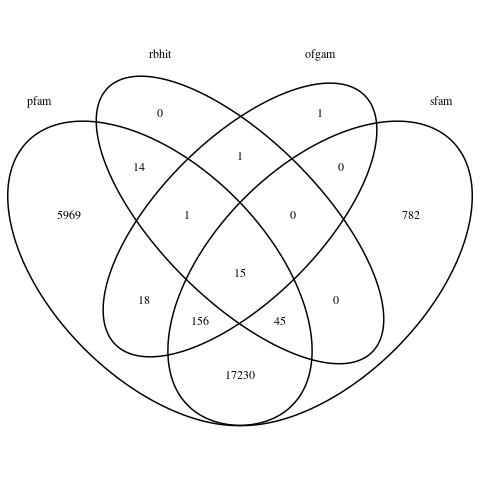

In [ ]:
%%R
# binary presence-absence table to quantify number of evidences
hysim_TFs_yesno <- data.frame(
  id = hysim_TFS_fulltable$id,
  pfam = ifelse(is.na(hysim_TFS_fulltable$PF), 0, 1),
  sfam = ifelse(is.na(hysim_TFS_fulltable$SF_domain), 0, 1),
  rbhit = ifelse(is.na(hysim_TFS_fulltable$rbhit_organism), 0, 1),
  ogfam = ifelse(is.na(hysim_TFS_fulltable$fam),0,1)
)

hysim_TFs_yesno_venn <- list(
  pfam = subset(hysim_TFs_yesno,pfam == 1)$id,
  sfam = subset(hysim_TFs_yesno,sfam == 1)$id,
  rbhit = subset(hysim_TFs_yesno,rbhit == 1)$id,
  ofgam = subset(hysim_TFs_yesno,ogfam == 1)$id
)

display_venn(hysim_TFs_yesno_venn)

In [ ]:
%%R
#Important: We count 2 sources of evidence as minimum
hysim_TFs_yesno$filt <-
  ifelse(
    rowSums(hysim_TFs_yesno[,2:5]) > 2,
    TRUE,
    FALSE
    )

hysim_TFS <- unique(
  hysim_TFS_fulltable[
    hysim_TFS_fulltable$id %in% hysim_TFs_yesno$id[hysim_TFs_yesno$filt == T]
    ,c(1,3,6,9,11,12)
    ]
  )

colnames(hysim_TFS) <- c(
  "id",
  "pfam_domain_name",
  "pfam_superfamily_name",
  "blastp_RBH_swissprotTFs",
  "orthofinder_animalTFDB_symbol",
  "orthofinder_animalTFDB_family"
)

write.table(
  hysim_TFS,
  "./20230717_hsym_TFs_precurated_V1.tsv",
  sep ="\t",
  quote = F,
  row.names=F
)

In [ ]:
%%R
head(hysim_TFS)

                id                                 pfam_domain_name
127 XP_057289338.1                                       PBC domain
128 XP_057289338.1           HOMEOBOX PROTEIN TRANSCRIPTION FACTORS
129 XP_057289338.1                                      Homeodomain
170 XP_057289355.1                                       Ets-domain
171 XP_057289355.1                                              ETS
314 XP_057289396.1 CYCLIN-D-BINDING MYB-LIKE TRANSCRIPTION FACTOR 1
              pfam_superfamily_name blastp_RBH_swissprotTFs
127                Homeodomain-like                    <NA>
128                Homeodomain-like                    <NA>
129                Homeodomain-like                    <NA>
170 Winged helix DNA-binding domain                    <NA>
171 Winged helix DNA-binding domain                    <NA>
314                Homeodomain-like                    <NA>
    orthofinder_animalTFDB_symbol orthofinder_animalTFDB_family
127            exd,pbx2,PBX4,Pbx2       

Remove duplicate or non-informative rows however you prefer  
(these are generated due to more than one kind of name for some pfam domains,
and to a lesser extent, some TFs having two identical domains and such)

In [ ]:
%%R
#dimensions with the last genome assembly
dim(hysim_TFS)

[1] 813   6


#### Create curated table with class and gene ID

In [ ]:
%%R
# manually curated list of TFs in 20230717_hsym_TFs_precurated_V1.tsv
hysim_tfs <- unique(
  read.table(
    "./20230725_hsym_TFs_curated_V3.tsv",
    sep ="\t",
    header = T
  )
)

In [ ]:
%%R
head(hysim_tfs$id)

[1] "LOC130612065" "LOC130612084" "LOC130612125" "LOC130612189" "LOC130612234"
[6] "LOC130612244"


In [ ]:
%%R
#hysim_tfs$class <- sub("-","_",hysim_tfs$class)
#hysim_tfs$id <- sub("\\.p.*","",hysim_tfs$id)

rownames(hysim_tfs) <-  NULL
hysim_tfs$id_class <- paste(
  hysim_tfs$id,
  hysim_tfs$class,
  sep = "_"
)

In [ ]:
%%R
head(hysim_tfs)

            id        class                  id_class
1 LOC130612065 Homeodomain  LOC130612065_Homeodomain 
2 LOC130612084          ETS          LOC130612084_ETS
3 LOC130612125          MYB          LOC130612125_MYB
4 LOC130612189      zf_C2H2      LOC130612189_zf_C2H2
5 LOC130612234          MYB          LOC130612234_MYB
6 LOC130612244      zf_C2H2      LOC130612244_zf_C2H2


In [ ]:
%%R
write.table(
  hysim_tfs,
  paste(
    "./",
    fcha(),
    "_hydractinia_TFs_curated.tsv",
    sep=""
  ),
  sep="\t",
  dec=".",
  row.names=F,
  quote=F
)